# 03 Data Preprocessing

Create train/val/test splits and data loaders for model training.

**Outputs:**
- Split indices saved to JSON for reproducibility
- DataLoader factory for training notebook

## Configuration

In [16]:
import json
from pathlib import Path
from datetime import datetime

# All configuration in one place
config = {
    # Paths
    'data_dir': Path('../data/CleanPetImages'),
    'output_dir': Path('../outputs'),
    'split_file': Path('../outputs/splits/train_val_test_split.json'),
    
    # Split ratios (val and test are from total, train is remainder)
    'val_ratio': 0.10,
    'test_ratio': 0.10,
    
    # Iteration subset - use smaller training set for fast experiments
    'use_subset': True,
    'subset_size': 4000,
    
    # DataLoader settings
    'batch_size': 32,
    'num_workers': 0,
    'pin_memory': True,
    
    # Image settings
    'image_size': 224,
    
    # Reproducibility
    'random_seed': 42,
}

# Create output directories
config['output_dir'].mkdir(parents=True, exist_ok=True)
(config['output_dir'] / 'splits').mkdir(exist_ok=True)

print("Configuration loaded")
print(f"  Data directory: {config['data_dir']}")
print(f"  Subset mode: {config['use_subset']} ({config['subset_size']} images)")

Configuration loaded
  Data directory: ..\data\CleanPetImages
  Subset mode: True (4000 images)


## Load File Paths

Load all image paths from the clean dataset.

In [17]:
def load_file_paths(data_dir):
    """
    Load all image paths from Cat and Dog folders.
    
    Returns:
        files: list of paths relative to data_dir (e.g., 'Cat/123.jpg')
        labels: list of int labels (0=cat, 1=dog)
    """
    data_dir = Path(data_dir)
    
    cat_files = sorted(data_dir.glob('Cat/*.jpg'))
    dog_files = sorted(data_dir.glob('Dog/*.jpg'))
    
    # Store as relative paths (portable across machines)
    files = []
    labels = []
    
    for f in cat_files:
        files.append(f'Cat/{f.name}')
        labels.append(0)
    
    for f in dog_files:
        files.append(f'Dog/{f.name}')
        labels.append(1)
    
    return files, labels


# Load the dataset
all_files, all_labels = load_file_paths(config['data_dir'])

# Quick summary
n_cats = sum(1 for label in all_labels if label == 0)
n_dogs = sum(1 for label in all_labels if label == 1)

print(f"Loaded {len(all_files)} images")
print(f"  Cats: {n_cats}")
print(f"  Dogs: {n_dogs}")

Loaded 24924 images
  Cats: 12456
  Dogs: 12468


## Train/Val/Test Split

Split the dataset with stratification to maintain class balance.

- Train: 80% (used for model training)
- Val: 10% (used for hyperparameter tuning)  
- Test: 10% (held out for final evaluation)

Val and test sets are fixed across all experiments. Only train set size changes when using subset mode.

In [18]:
from sklearn.model_selection import train_test_split
import numpy as np

def create_splits(files, labels, val_ratio, test_ratio, random_seed):
    """
    Create stratified train/val/test splits.
    
    Args:
        files: list of file paths
        labels: list of labels (0 or 1)
        val_ratio: fraction for validation (e.g., 0.10)
        test_ratio: fraction for test (e.g., 0.10)
        random_seed: for reproducibility
    
    Returns:
        dict with train_files, val_files, test_files, and corresponding labels
    """
    # First split: separate test set
    train_val_files, test_files, train_val_labels, test_labels = train_test_split(
        files, 
        labels,
        test_size=test_ratio,
        stratify=labels,
        random_state=random_seed
    )
    
    # Second split: separate val from train
    # Adjust val_ratio since we're splitting from (1 - test_ratio)
    adjusted_val_ratio = val_ratio / (1 - test_ratio)
    
    train_files, val_files, train_labels, val_labels = train_test_split(
        train_val_files,
        train_val_labels,
        test_size=adjusted_val_ratio,
        stratify=train_val_labels,
        random_state=random_seed
    )
    
    return {
        'train_files': train_files,
        'train_labels': train_labels,
        'val_files': val_files,
        'val_labels': val_labels,
        'test_files': test_files,
        'test_labels': test_labels,
    }


# Create the splits
splits = create_splits(
    all_files, 
    all_labels,
    val_ratio=config['val_ratio'],
    test_ratio=config['test_ratio'],
    random_seed=config['random_seed']
)

print("Split sizes:")
print(f"  Train: {len(splits['train_files'])}")
print(f"  Val:   {len(splits['val_files'])}")
print(f"  Test:  {len(splits['test_files'])}")

Split sizes:
  Train: 19938
  Val:   2493
  Test:  2493


In [19]:
def print_class_distribution(labels, name):
    """Print class balance for a split."""
    labels = np.array(labels)
    n_cats = np.sum(labels == 0)
    n_dogs = np.sum(labels == 1)
    total = len(labels)
    
    print(f"{name}:")
    print(f"  Cats: {n_cats} ({100*n_cats/total:.1f}%)")
    print(f"  Dogs: {n_dogs} ({100*n_dogs/total:.1f}%)")


# Verify stratification maintained class balance
print("Class distribution (should be ~50/50 in each):\n")
print_class_distribution(splits['train_labels'], "Train")
print()
print_class_distribution(splits['val_labels'], "Val")
print()
print_class_distribution(splits['test_labels'], "Test")

Class distribution (should be ~50/50 in each):

Train:
  Cats: 9964 (50.0%)
  Dogs: 9974 (50.0%)

Val:
  Cats: 1246 (50.0%)
  Dogs: 1247 (50.0%)

Test:
  Cats: 1246 (50.0%)
  Dogs: 1247 (50.0%)


## Create Iteration Subset

Select a fixed subset of training data for fast hyperparameter iteration.
The subset is stratified to maintain class balance.

In [20]:
def create_subset_indices(train_labels, subset_size, random_seed):
    """
    Select stratified subset indices from training set.
    
    Args:
        train_labels: labels for training set
        subset_size: number of samples for subset
        random_seed: for reproducibility
    
    Returns:
        list of indices into the training set
    """
    n_train = len(train_labels)
    
    if subset_size >= n_train:
        print(f"Subset size ({subset_size}) >= train size ({n_train}), using all training data")
        return list(range(n_train))
    
    # Use train_test_split to get stratified subset
    all_indices = list(range(n_train))
    subset_ratio = subset_size / n_train
    
    subset_indices, _ = train_test_split(
        all_indices,
        train_size=subset_ratio,
        stratify=train_labels,
        random_state=random_seed
    )
    
    return sorted(subset_indices)


# Create subset indices
subset_indices = create_subset_indices(
    splits['train_labels'],
    config['subset_size'],
    config['random_seed']
)

# Verify subset
subset_labels = [splits['train_labels'][i] for i in subset_indices]
print(f"Subset size: {len(subset_indices)}")
print()
print_class_distribution(subset_labels, "Subset")

Subset size: 3999

Subset:
  Cats: 1998 (50.0%)
  Dogs: 2001 (50.0%)


## Save Splits to JSON

Save all split information for reproducibility across notebooks.

In [21]:
def save_splits(splits, subset_indices, config):
    """Save splits to JSON file."""
    
    split_data = {
        'train_files': splits['train_files'],
        'train_labels': splits['train_labels'],
        'val_files': splits['val_files'],
        'val_labels': splits['val_labels'],
        'test_files': splits['test_files'],
        'test_labels': splits['test_labels'],
        'subset_indices': subset_indices,
        'config': {
            'val_ratio': config['val_ratio'],
            'test_ratio': config['test_ratio'],
            'subset_size': config['subset_size'],
            'random_seed': config['random_seed'],
        },
        'created': datetime.now().isoformat(),
    }
    
    with open(config['split_file'], 'w') as f:
        json.dump(split_data, f, indent=2)
    
    print(f"Splits saved to {config['split_file']}")


# Save
save_splits(splits, subset_indices, config)

Splits saved to ..\outputs\splits\train_val_test_split.json


In [22]:
# Quick verification - reload and check
with open(config['split_file'], 'r') as f:
    loaded = json.load(f)

print("Verification - reloaded from JSON:")
print(f"  Train files: {len(loaded['train_files'])}")
print(f"  Val files:   {len(loaded['val_files'])}")
print(f"  Test files:  {len(loaded['test_files'])}")
print(f"  Subset indices: {len(loaded['subset_indices'])}")
print(f"  Random seed: {loaded['config']['random_seed']}")

Verification - reloaded from JSON:
  Train files: 19938
  Val files:   2493
  Test files:  2493
  Subset indices: 3999
  Random seed: 42


## Dataset Class

PyTorch Dataset for loading cat and dog images.

The Dataset class defines how to load a single item. PyTorch's DataLoader 
handles batching, shuffling, and parallel loading automatically.

In [23]:
import cv2
import torch
from torch.utils.data import Dataset


class CatsDogsDataset(Dataset):
    """
    Dataset for cats vs dogs classification.
    
    Uses OpenCV for fast image loading. Compatible with Albumentations transforms.
    
    Args:
        file_list: list of relative paths (e.g., 'Cat/123.jpg')
        labels: list of labels (0=cat, 1=dog)
        data_dir: root directory containing Cat/ and Dog/ folders
        transform: albumentations transform to apply
    """
    
    def __init__(self, file_list, labels, data_dir, transform=None):
        self.file_list = file_list
        self.labels = labels
        self.data_dir = Path(data_dir)
        self.transform = transform
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        # Get path and label
        rel_path = self.file_list[index]
        label = self.labels[index]
        
        # Load image with OpenCV (faster than PIL)
        img_path = str(self.data_dir / rel_path)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV loads BGR, convert to RGB
        
        # Apply albumentations transform
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']
        
        return image, label

In [24]:
# Quick test - verify loading works

test_dataset = CatsDogsDataset(
    file_list=splits['train_files'][:5],
    labels=splits['train_labels'][:5],
    data_dir=config['data_dir'],
    transform=None  # raw numpy arrays for now
)

print(f"Dataset length: {len(test_dataset)}")

# Load one image
image, label = test_dataset[0]
print(f"Image type: {type(image)}")
print(f"Image shape: {image.shape}")  # numpy array is (H, W, C)
print(f"Image dtype: {image.dtype}")
print(f"Label: {label} ({'cat' if label == 0 else 'dog'})")

Dataset length: 5
Image type: <class 'numpy.ndarray'>
Image shape: (375, 500, 3)
Image dtype: uint8
Label: 1 (dog)


## Image Transforms

Using Albumentations for fast, numpy-based transforms.

**Why Albumentations over torchvision?**
- Faster: OpenCV/numpy backend vs PIL
- More flexible: easier to add/remove augmentations
- Industry standard for computer vision competitions and production

**Training transforms:** resize + augmentation + normalize + to tensor  
**Validation transforms:** resize + normalize + to tensor (no augmentation)

In [25]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


# ImageNet statistics (required for pretrained models)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]


def get_train_transforms(image_size=224):
    """
    Training transforms with augmentation.
    
    Augmentation choices:
    - HorizontalFlip: cats/dogs can face either direction
    - RandomRotation: slight tilts are natural in photos
    - ColorJitter: photos have varying lighting conditions
    
    Kept simple intentionally. More aggressive augmentation
    can be tested during hyperparameter tuning.
    """
    return A.Compose([
        A.Resize(image_size, image_size),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=10, p=0.5),
        A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05, p=0.5),
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ToTensorV2(),
    ])


def get_val_transforms(image_size=224):
    """
    Validation/test transforms. No augmentation - consistent evaluation.
    """
    return A.Compose([
        A.Resize(image_size, image_size),
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ToTensorV2(),
    ])

In [26]:
# Test transforms

train_transforms = get_train_transforms(config['image_size'])
val_transforms = get_val_transforms(config['image_size'])

# Create test dataset with transforms
test_dataset_with_transforms = CatsDogsDataset(
    file_list=splits['train_files'][:5],
    labels=splits['train_labels'][:5],
    data_dir=config['data_dir'],
    transform=train_transforms
)

# Load one image
image, label = test_dataset_with_transforms[0]
print(f"Image type: {type(image)}")
print(f"Image shape: {image.shape}")  # should be (C, H, W) = (3, 224, 224)
print(f"Image dtype: {image.dtype}")
print(f"Value range: [{image.min():.2f}, {image.max():.2f}]")  # normalized, not 0-255
print(f"Label: {label}")

Image type: <class 'torch.Tensor'>
Image shape: torch.Size([3, 224, 224])
Image dtype: torch.float32
Value range: [-2.12, 2.62]
Label: 1


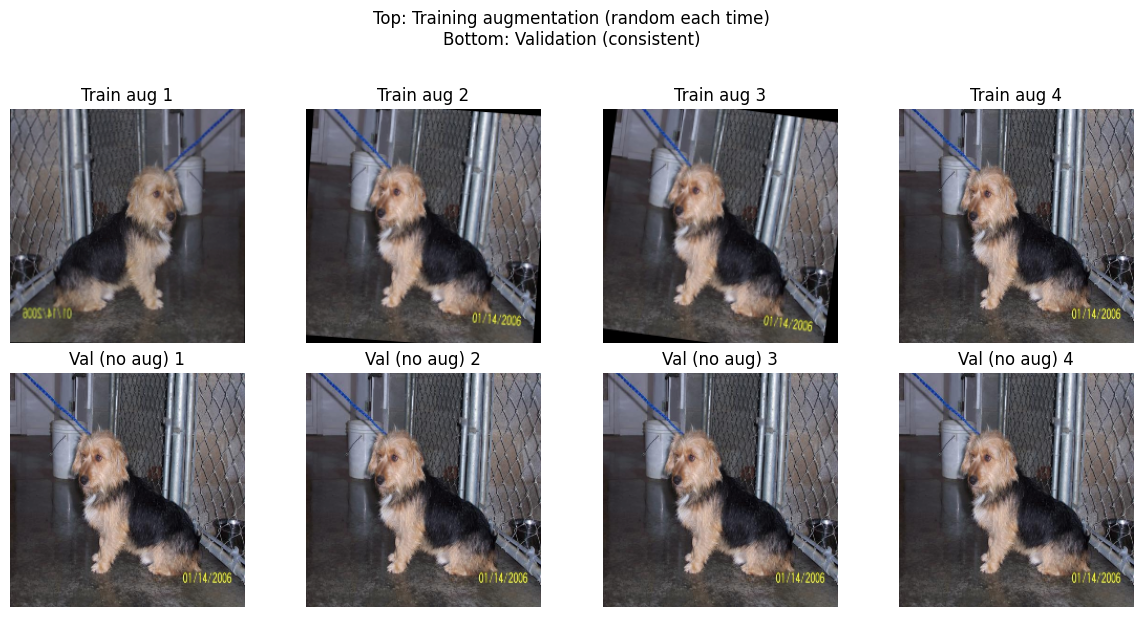

In [27]:
# Visual verification - show same image with and without augmentation

import matplotlib.pyplot as plt

def show_image(tensor, title, ax):
    """Convert normalized tensor back to displayable image."""
    img = tensor.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
    
    # Denormalize
    mean = np.array(IMAGENET_MEAN)
    std = np.array(IMAGENET_STD)
    img = img * std + mean
    img = np.clip(img, 0, 1)
    
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')


# Load same image multiple times with training transforms (random augmentation)
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Top row: same image with different random augmentations
for i in range(4):
    image, label = test_dataset_with_transforms[0]  # same index, different augmentation each time
    show_image(image, f'Train aug {i+1}', axes[0, i])

# Bottom row: same image with validation transforms (no augmentation, consistent)
val_dataset = CatsDogsDataset(
    file_list=splits['train_files'][:5],
    labels=splits['train_labels'][:5],
    data_dir=config['data_dir'],
    transform=val_transforms
)

for i in range(4):
    image, label = val_dataset[0]  # same index, should look identical each time
    show_image(image, f'Val (no aug) {i+1}', axes[1, i])

plt.suptitle('Top: Training augmentation (random each time)\nBottom: Validation (consistent)', y=1.02)
plt.tight_layout()
plt.show()

## DataLoader Factory

Creates train, validation, and test DataLoaders with appropriate settings.

Supports subset mode for fast iteration during hyperparameter tuning.

In [28]:
from torch.utils.data import DataLoader


def create_dataloaders(split_data, config, train_transform, val_transform):
    """
    Create DataLoaders for train, validation, and test sets.
    
    Args:
        split_data: dict with train_files, val_files, test_files, labels, subset_indices
        config: dict with batch_size, num_workers, use_subset, etc.
        train_transform: albumentations transform for training
        val_transform: albumentations transform for validation/test
    
    Returns:
        train_loader, val_loader, test_loader
    """
    data_dir = config['data_dir']
    
    # Get file lists
    train_files = split_data['train_files']
    train_labels = split_data['train_labels']
    
    # Use subset if configured
    if config['use_subset']:
        subset_indices = split_data['subset_indices']
        train_files = [train_files[i] for i in subset_indices]
        train_labels = [train_labels[i] for i in subset_indices]
    
    # Create datasets
    train_dataset = CatsDogsDataset(train_files, train_labels, data_dir, train_transform)
    val_dataset = CatsDogsDataset(split_data['val_files'], split_data['val_labels'], data_dir, val_transform)
    test_dataset = CatsDogsDataset(split_data['test_files'], split_data['test_labels'], data_dir, val_transform)
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=config['num_workers'],
        pin_memory=config['pin_memory'],
        persistent_workers=config['num_workers'] > 0,  # ADD THIS
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=config['num_workers'],
        pin_memory=config['pin_memory'],
        persistent_workers=config['num_workers'] > 0,  # ADD THIS
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=config['num_workers'],
        pin_memory=config['pin_memory'],
        persistent_workers=config['num_workers'] > 0,  # ADD THIS
    )
    
    return train_loader, val_loader, test_loader

In [29]:
# Load split data from JSON
with open(config['split_file'], 'r') as f:
    split_data = json.load(f)

# Create transforms
train_transforms = get_train_transforms(config['image_size'])
val_transforms = get_val_transforms(config['image_size'])

# Create dataloaders
train_loader, val_loader, test_loader = create_dataloaders(
    split_data, 
    config, 
    train_transforms, 
    val_transforms
)

print(f"Subset mode: {config['use_subset']}")
print(f"Batch size: {config['batch_size']}")
print()
print(f"Train: {len(train_loader.dataset)} images, {len(train_loader)} batches")
print(f"Val:   {len(val_loader.dataset)} images, {len(val_loader)} batches")
print(f"Test:  {len(test_loader.dataset)} images, {len(test_loader)} batches")

Subset mode: True
Batch size: 32

Train: 3999 images, 125 batches
Val:   2493 images, 78 batches
Test:  2493 images, 78 batches


In [30]:
# Verify a batch loads correctly

images, labels = next(iter(train_loader))

print(f"Batch images shape: {images.shape}")
print(f"Batch labels shape: {labels.shape}")
print(f"Labels in batch: {labels[:10].tolist()}...")

Batch images shape: torch.Size([32, 3, 224, 224])
Batch labels shape: torch.Size([32])
Labels in batch: [0, 1, 1, 1, 1, 1, 0, 0, 1, 1]...


## Verification and Visualization

Visual check that everything works correctly.

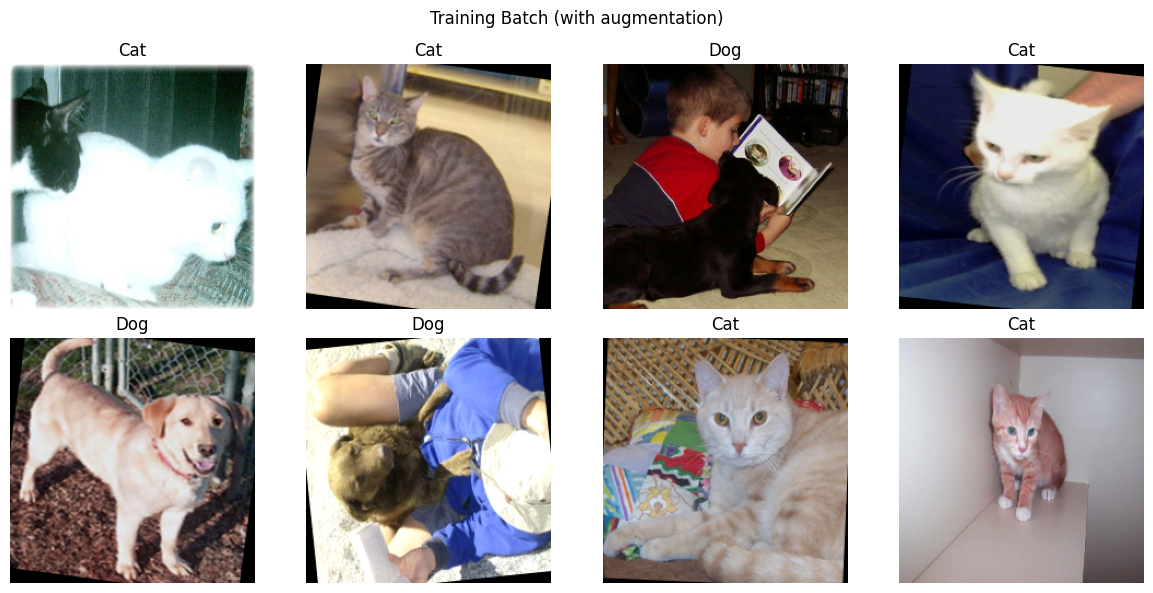

In [31]:
import matplotlib.pyplot as plt

def show_batch(images, labels, title="Batch"):
    """Display a batch of images."""
    # Denormalize for display
    mean = torch.tensor(IMAGENET_MEAN).view(3, 1, 1)
    std = torch.tensor(IMAGENET_STD).view(3, 1, 1)
    
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    fig.suptitle(title)
    
    for i, ax in enumerate(axes.flat):
        if i >= len(images):
            ax.axis('off')
            continue
        
        img = images[i] * std + mean  # denormalize
        img = img.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
        img = np.clip(img, 0, 1)
        
        label_name = 'Cat' if labels[i] == 0 else 'Dog'
        ax.imshow(img)
        ax.set_title(label_name)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


# Show a batch from training loader
images, labels = next(iter(train_loader))
show_batch(images, labels, "Training Batch (with augmentation)")

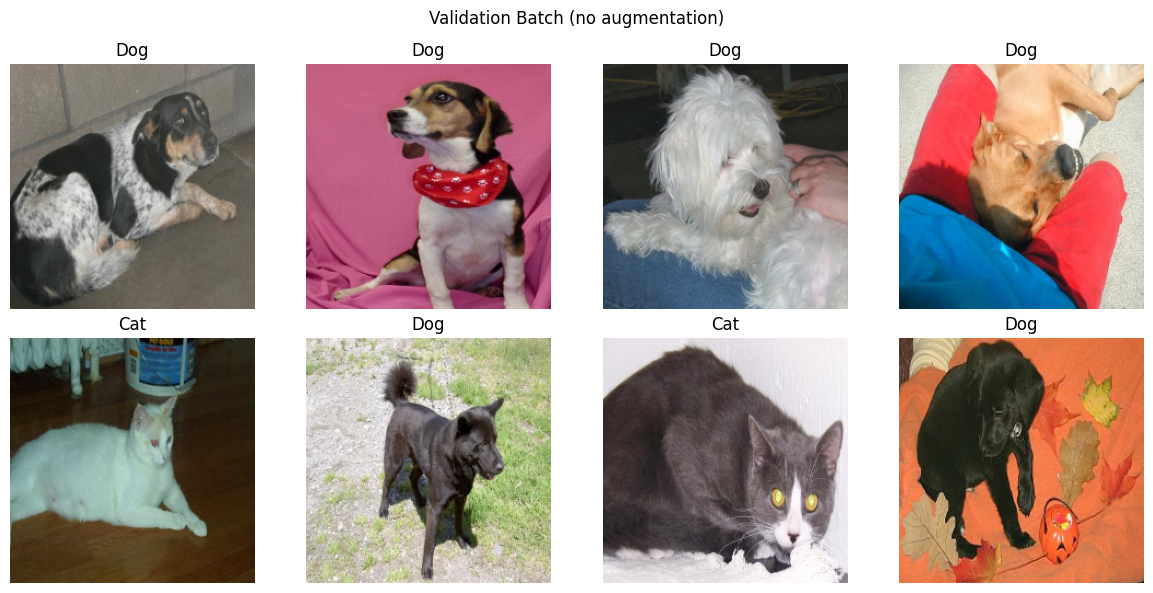

In [32]:
# Show same images from validation loader (no augmentation)
val_images, val_labels = next(iter(val_loader))
show_batch(val_images, val_labels, "Validation Batch (no augmentation)")

## Summary

Preprocessing complete. Ready for training in scripts section of this project